In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from data import get_names

In [2]:
def get_available_device() -> str:
    """Returns the device based on the system configuration."""
    if torch.cuda.is_available():
        return torch.device('cuda').type
    if torch.backends.mps.is_available():
        return torch.device('mps').type  # https://pytorch.org/docs/stable/notes/mps.html
    return torch.device('cpu').type

device = get_available_device()
print(f"Using device: {device}")

Using device: cpu


In [3]:
words = get_names()
print(words[:5])

['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [4]:
characters = ['.', *sorted({c for w in words for c in w})]
print(characters)
print(len(characters))
index = {
    c:i
    for i, c in enumerate(characters)
}
index
print(index)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27
{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [5]:
# create the training set of all of the bigrams
# x is the input, y is the target (i.e. the next character)
x, y = [], []
training_data = []
for w in words:
    chars = ['.',  *w, '.']
    for c1, c2 in zip(chars, chars[1:]):
        x.append(index[c1])
        y.append(index[c2])

x = np.array(x)
y = np.array(y)

print(x[:10])
print(y[:10])

[ 0  5 13 13  1  0 15 12  9 22]
[ 5 13 13  1  0 15 12  9 22  9]


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]


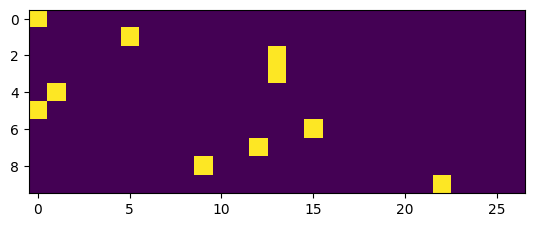

In [6]:
# encode
def one_hot_encode(index: int) -> np.array:
    """Return a one-hot encoded vector of the given index."""
    vector = np.zeros(len(characters))
    vector[index] = 1
    return vector

x_encoded = np.array([one_hot_encode(i) for i in x])
y_encoded = np.array([one_hot_encode(i) for i in y])

print(x_encoded[:6])
plt.imshow(x_encoded[0:10])

In [7]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    """A Multilayer Perceptron (MLP) model in PyTorch with one hidden layer."""

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(27, 50),
            nn.ReLU(),
            nn.Linear(50, 27),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x: Input tensor.

        Returns:
            Tensor after passing through the layers and activations.
        """
        return self.layers(x)

learning_rate = 0.01
epochs = 15
batch_size = 32

x_encoded = torch.tensor(x_encoded, dtype=torch.float).to(device)
y_encoded = torch.tensor(y_encoded, dtype=torch.float).to(device)

dataset = TensorDataset(x_encoded, y_encoded)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = MLP()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
losses = []
val_losses = []

for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        if i % 200 == 0:
            losses.append(loss.item())
            print(f"Epoch {epoch}, Batch {i:04}, training loss {round(loss.item(), 3)}")
print(f"Epoch {epoch}, Batch {i:04}, training loss {round(loss.item(), 3)}")

Epoch 0, Batch 0000, training loss 3.325
Epoch 0, Batch 0200, training loss 3.236
Epoch 0, Batch 0400, training loss 3.11
Epoch 0, Batch 0600, training loss 2.989
Epoch 0, Batch 0800, training loss 2.848
Epoch 0, Batch 1000, training loss 2.984
Epoch 0, Batch 1200, training loss 2.713
Epoch 0, Batch 1400, training loss 2.868
Epoch 0, Batch 1600, training loss 2.725
Epoch 0, Batch 1800, training loss 2.793
Epoch 0, Batch 2000, training loss 2.79
Epoch 0, Batch 2200, training loss 2.849
Epoch 0, Batch 2400, training loss 2.697
Epoch 0, Batch 2600, training loss 2.987
Epoch 0, Batch 2800, training loss 2.767
Epoch 0, Batch 3000, training loss 2.688
Epoch 0, Batch 3200, training loss 2.6
Epoch 0, Batch 3400, training loss 2.693
Epoch 0, Batch 3600, training loss 3.018
Epoch 0, Batch 3800, training loss 2.659
Epoch 0, Batch 4000, training loss 2.747
Epoch 0, Batch 4200, training loss 2.687
Epoch 0, Batch 4400, training loss 2.862
Epoch 0, Batch 4600, training loss 2.803
Epoch 0, Batch 4800,

KeyboardInterrupt: 

In [ ]:
# plot losses over time
plt.plot(losses)